In [1]:
# import packages
library(tidyverse)
library(tidymodels)
library(mlr)
library(knitr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
# load data and data wrangling
heart <- read_csv("processed.cleveland.data", col_names = FALSE)
colnames(heart) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                     "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
heart <- heart |>
    mutate(disease = as.factor(case_when(num == 0 ~ 'no', num > 0 ~ 'yes'))) |>
    mutate(sex = as.factor(sex), cp = as.factor(cp), fbs = as.factor(fbs),
           restecg = as.factor(restecg), exang = as.factor(exang), slope = as.factor(slope),
           ca = as.numeric(ca), thal = as.factor(thal), num = as.factor(num))
heart[heart == "?"] <- NA
#summarizeColumns(heart) |> kable(caption = 'Summary of data before removing missing values')
head(heart)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `ca = as.numeric(ca)`.
Caused by warning:
! NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,disease
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0,no
67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,2,yes
67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,1,yes
37,1,3,130,250,0,0,187,0,3.5,3,0,3.0,0,no
41,0,2,130,204,0,2,172,0,1.4,1,0,3.0,0,no
56,1,2,120,236,0,0,178,0,0.8,1,0,3.0,0,no


In [3]:
# remove missing values
heart <- na.omit(heart)
summary(heart)

      age        sex     cp         trestbps          chol       fbs    
 Min.   :29.00   0: 96   1: 23   Min.   : 94.0   Min.   :126.0   0:254  
 1st Qu.:48.00   1:201   2: 49   1st Qu.:120.0   1st Qu.:211.0   1: 43  
 Median :56.00           3: 83   Median :130.0   Median :243.0          
 Mean   :54.54           4:142   Mean   :131.7   Mean   :247.4          
 3rd Qu.:61.00                   3rd Qu.:140.0   3rd Qu.:276.0          
 Max.   :77.00                   Max.   :200.0   Max.   :564.0          
 restecg    thalach      exang      oldpeak      slope         ca        
 0:147   Min.   : 71.0   0:200   Min.   :0.000   1:139   Min.   :0.0000  
 1:  4   1st Qu.:133.0   1: 97   1st Qu.:0.000   2:137   1st Qu.:0.0000  
 2:146   Median :153.0           Median :0.800   3: 21   Median :0.0000  
         Mean   :149.6           Mean   :1.056           Mean   :0.6768  
         3rd Qu.:166.0           3rd Qu.:1.600           3rd Qu.:1.0000  
         Max.   :202.0           Max.   :6.20

In [4]:
# split data
heart_split <- initial_split(heart, prop = 0.75, strata = disease)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)
summarizeColumns(heart_train) |> kable(caption = 'Summary of training data')



Table: Summary of training data

|name     |type    | na|        mean|       disp| median|      mad| min|   max| nlevs|
|:--------|:-------|--:|-----------:|----------:|------:|--------:|---:|-----:|-----:|
|age      |numeric |  0|  54.3783784|  8.9012217|   56.0|  8.89560|  34|  76.0|     0|
|sex      |factor  |  0|          NA|  0.3243243|     NA|       NA|  72| 150.0|     2|
|cp       |factor  |  0|          NA|  0.5180180|     NA|       NA|  19| 107.0|     4|
|trestbps |numeric |  0| 132.2927928| 18.4577258|  130.0| 14.82600|  94| 200.0|     0|
|chol     |numeric |  0| 246.9954955| 50.9140432|  242.0| 45.96060| 131| 564.0|     0|
|fbs      |factor  |  0|          NA|  0.1441441|     NA|       NA|  32| 190.0|     2|
|restecg  |factor  |  0|          NA|  0.5000000|     NA|       NA|   4| 111.0|     3|
|thalach  |numeric |  0| 149.6171171| 23.4418946|  153.0| 22.23900|  71| 195.0|     0|
|exang    |factor  |  0|          NA|  0.3423423|     NA|       NA|  76| 146.0|     2|
|oldpeak

In [5]:
# data summary
heart_summary <- heart_train |>
                 group_by(disease) |>
                 summarize(observations = n(), mean_age = mean(age), mean_trestbps = mean(trestbps), mean_chol = mean(chol),
                 mean_thalach = mean(thalach), mean_oldpeak = mean(oldpeak))
heart_summary

disease,observations,mean_age,mean_trestbps,mean_chol,mean_thalach,mean_oldpeak
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,120,52.55833,129.2167,244.6833,159.1333,0.6116667
yes,102,56.51961,135.9118,249.7157,138.4216,1.7107843


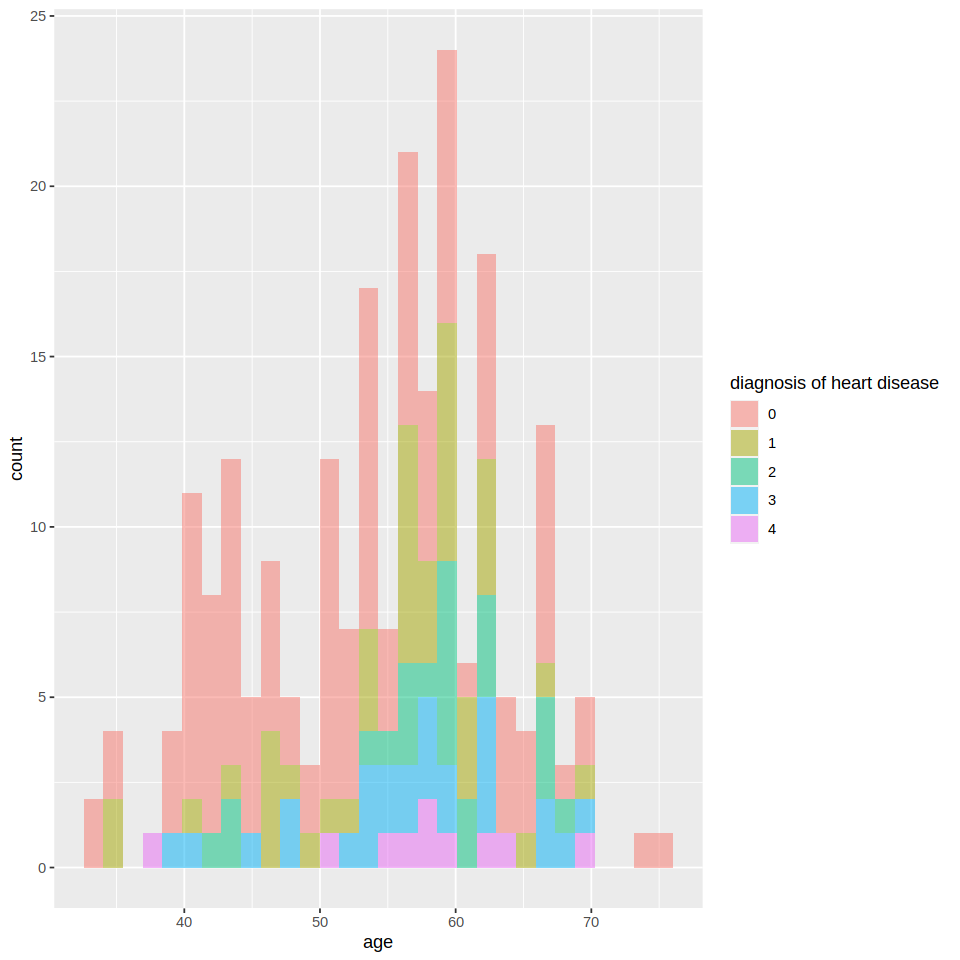

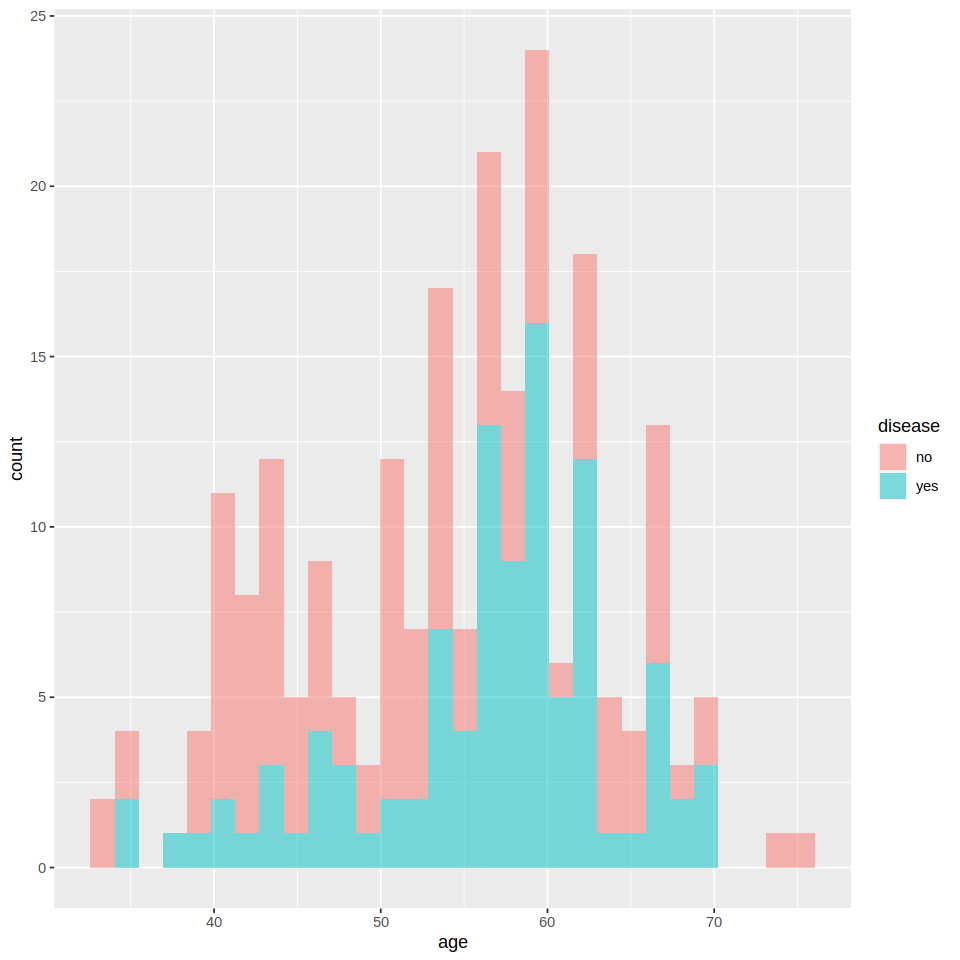

In [6]:
# plots
options(repr.plot.width = 8, repr.plot.height = 8)
age_num_plot <- heart_train |>
      ggplot() +
      geom_histogram(aes(x = age, fill = num), alpha = 0.5, bins = 30)+
      labs(x = "age", 
      y = "count", 
      fill = "diagnosis of heart disease")
age_num_plot
age_disease_plot <- heart_train |>
      ggplot() +
      geom_histogram(aes(x = age, fill = disease), alpha = 0.5, bins = 30)+
      labs(x = "age", 
      y = "count", 
      fill = "disease")
age_disease_plot

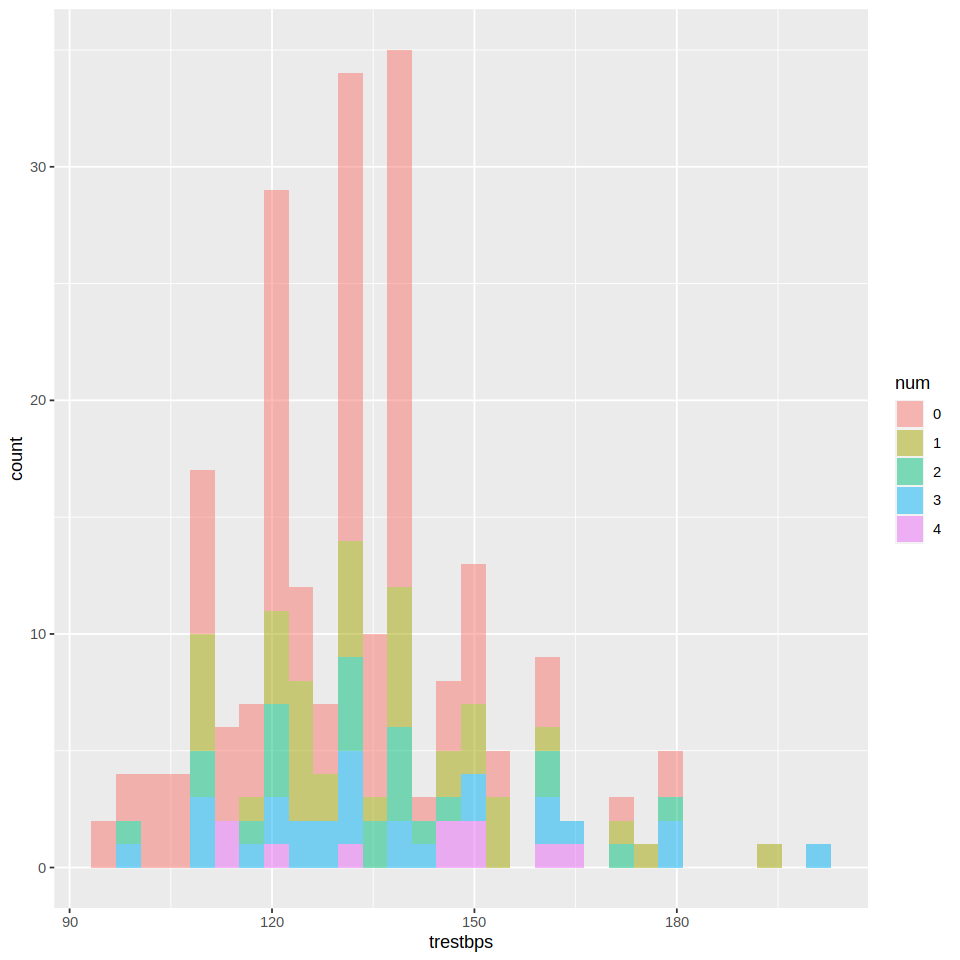

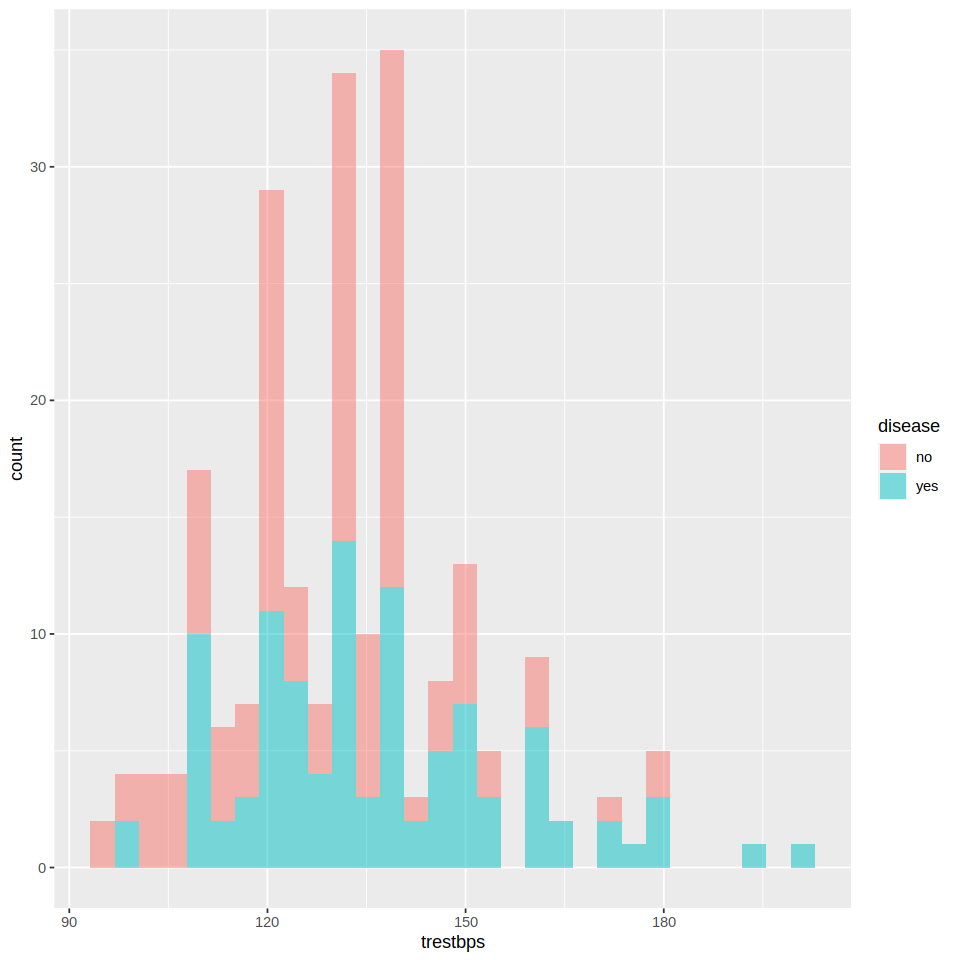

In [7]:
options(repr.plot.width = 8, repr.plot.height = 8)
trestbps_num_plot <- heart_train |>
      ggplot() +
      geom_histogram(aes(x = trestbps, fill = num), alpha = 0.5, bins = 30)
trestbps_num_plot
trestbps_disease_plot <- heart_train |>
      ggplot() +
      geom_histogram(aes(x = trestbps, fill = disease), alpha = 0.5, bins = 30)
trestbps_disease_plot

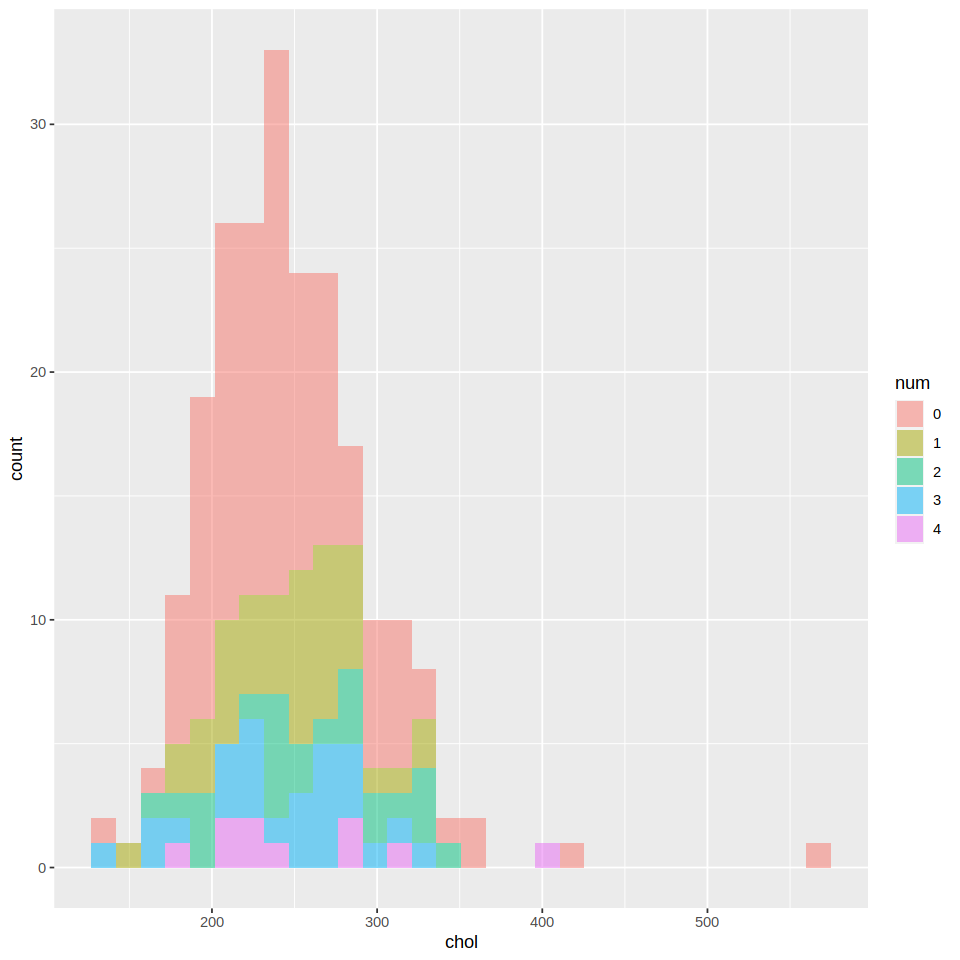

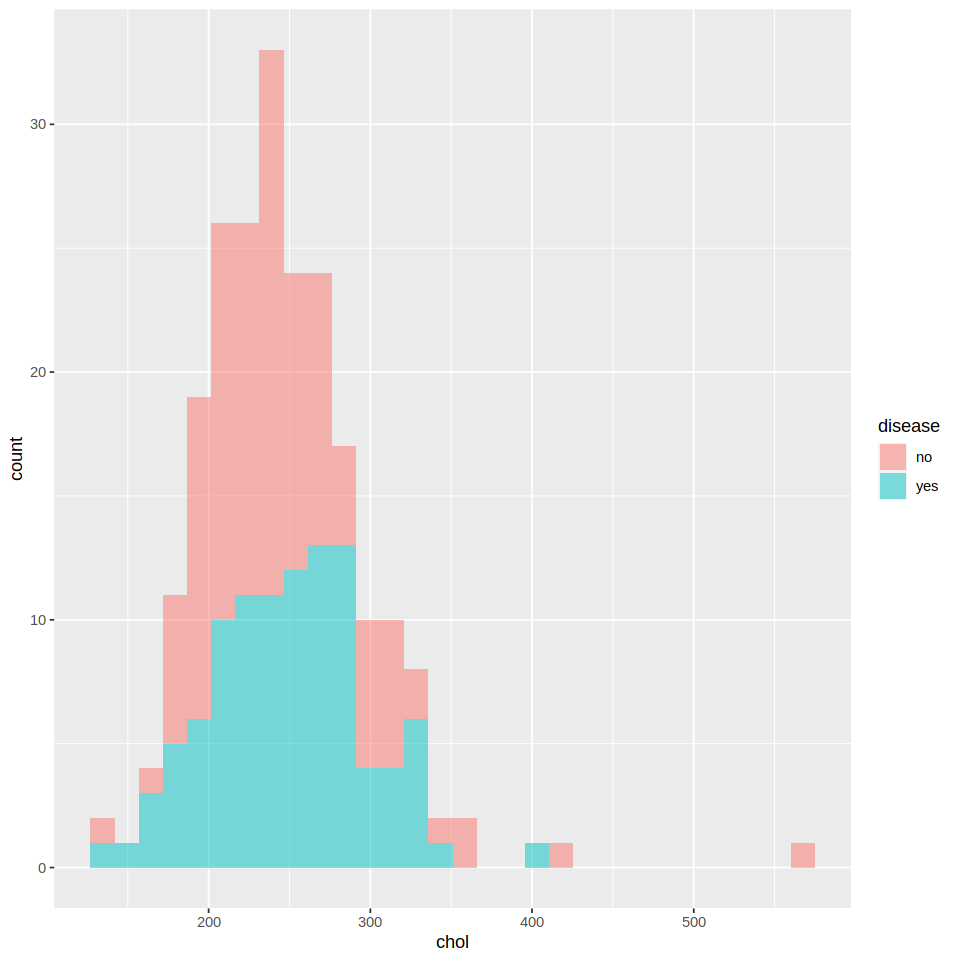

In [8]:
options(repr.plot.width = 8, repr.plot.height = 8)
chol_num_plot <- heart_train |>
      ggplot() +
      geom_histogram(aes(x = chol, fill = num), alpha = 0.5, bins = 30)
chol_num_plot
chol_disease_plot <- heart_train |>
      ggplot() +
      geom_histogram(aes(x = chol, fill = disease), alpha = 0.5, bins = 30)
chol_disease_plot

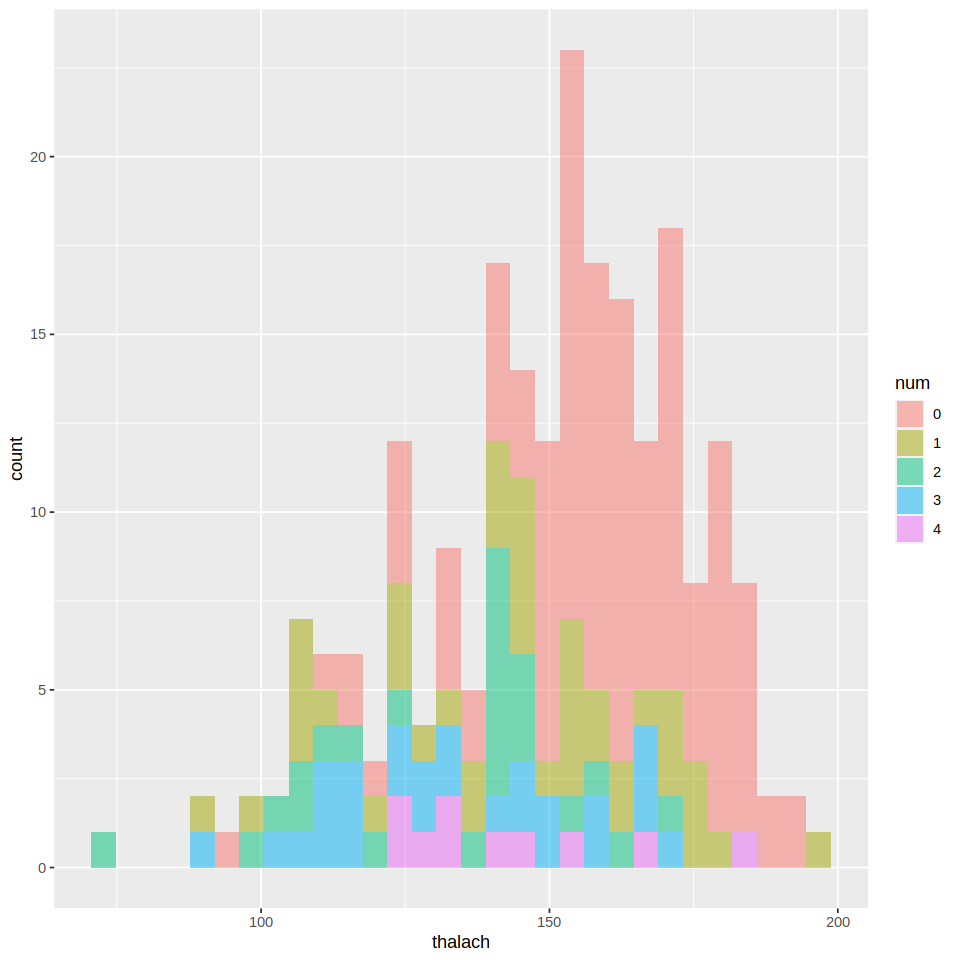

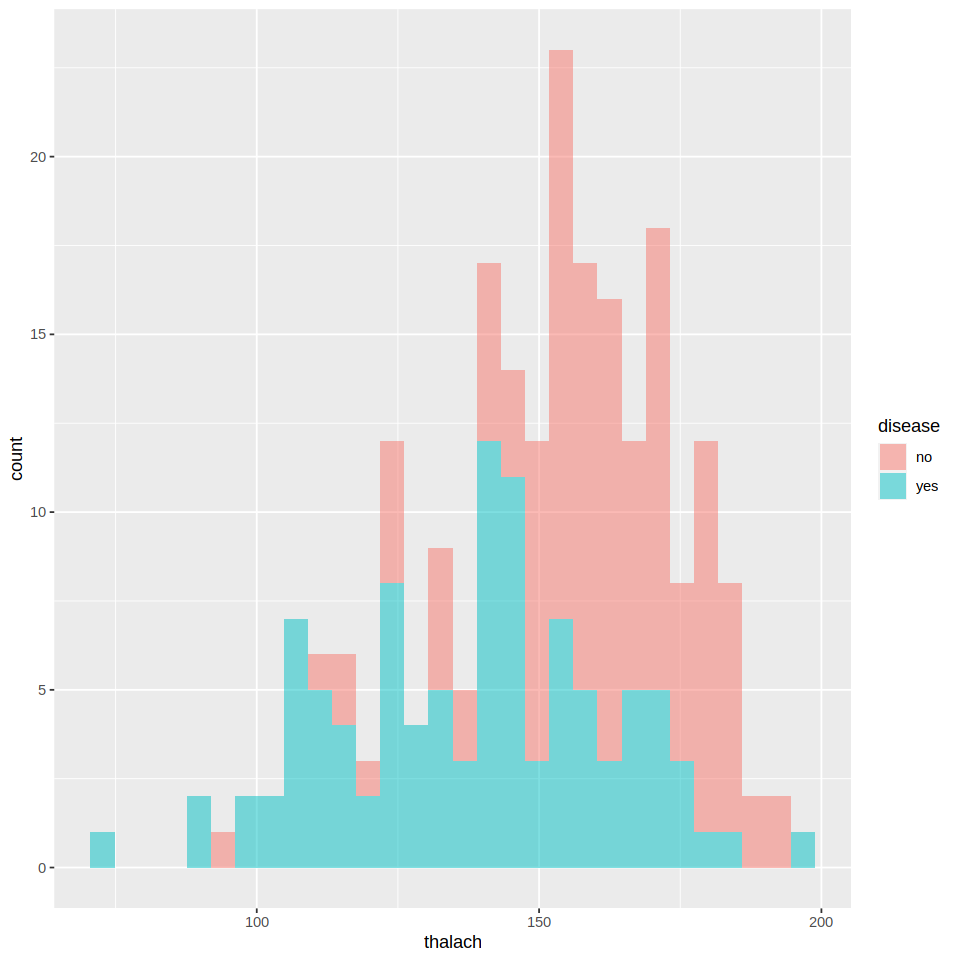

In [9]:
options(repr.plot.width = 8, repr.plot.height = 8)
thalach_num_plot <- heart_train |>
      ggplot() +
      geom_histogram(aes(x = thalach, fill = num), alpha = 0.5, bins = 30)
thalach_num_plot
thalach_disease_plot <- heart_train |>
      ggplot() +
      geom_histogram(aes(x = thalach, fill = disease), alpha = 0.5, bins = 30)
thalach_disease_plot

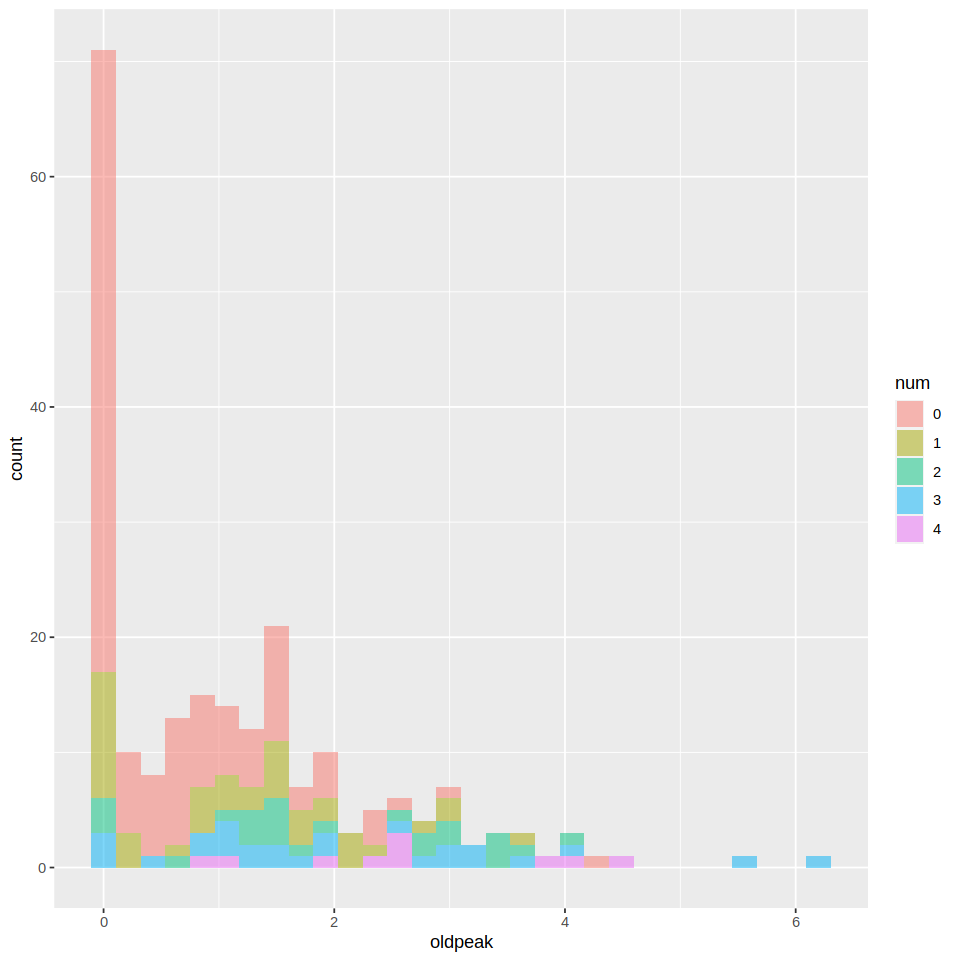

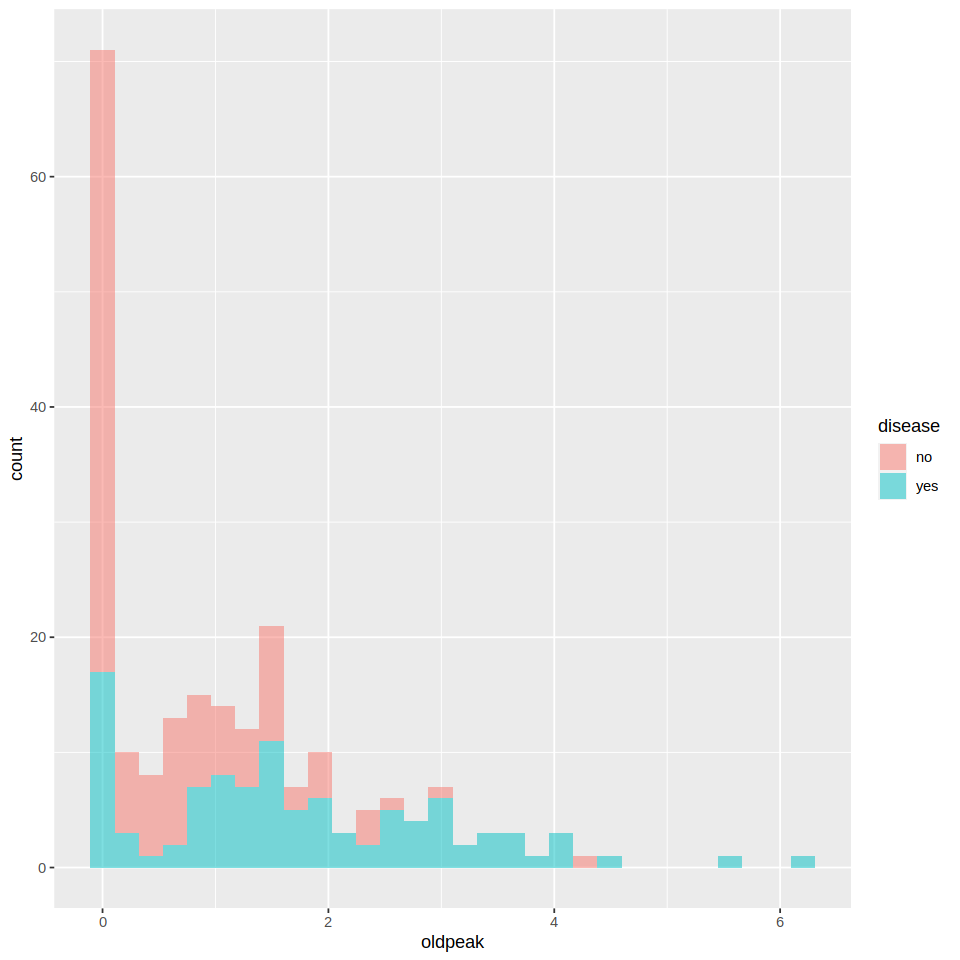

In [10]:
options(repr.plot.width = 8, repr.plot.height = 8)
oldpeak_num_plot <- heart_train |>
      ggplot() +
      geom_histogram(aes(x = oldpeak, fill = num), alpha = 0.5, bins = 30)
oldpeak_num_plot
oldpeak_disease_plot <- heart_train |>
      ggplot() +
      geom_histogram(aes(x = oldpeak, fill = disease), alpha = 0.5, bins = 30)
oldpeak_disease_plot

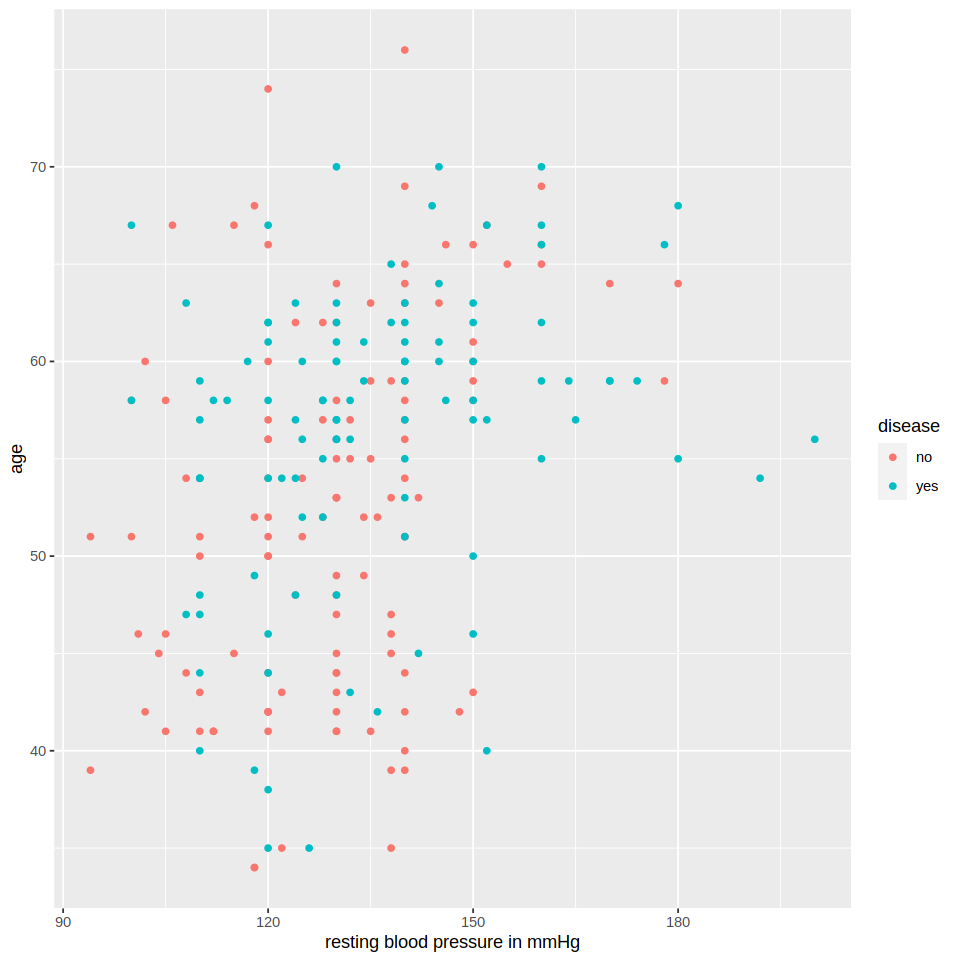

In [11]:
trestbps_age_plot <- ggplot(heart_train, aes(x = trestbps, y = age, color = disease)) +
                 geom_point() +
                 labs(x = "resting blood pressure in mmHg", y = "age", color = "disease")
                 
trestbps_age_plot

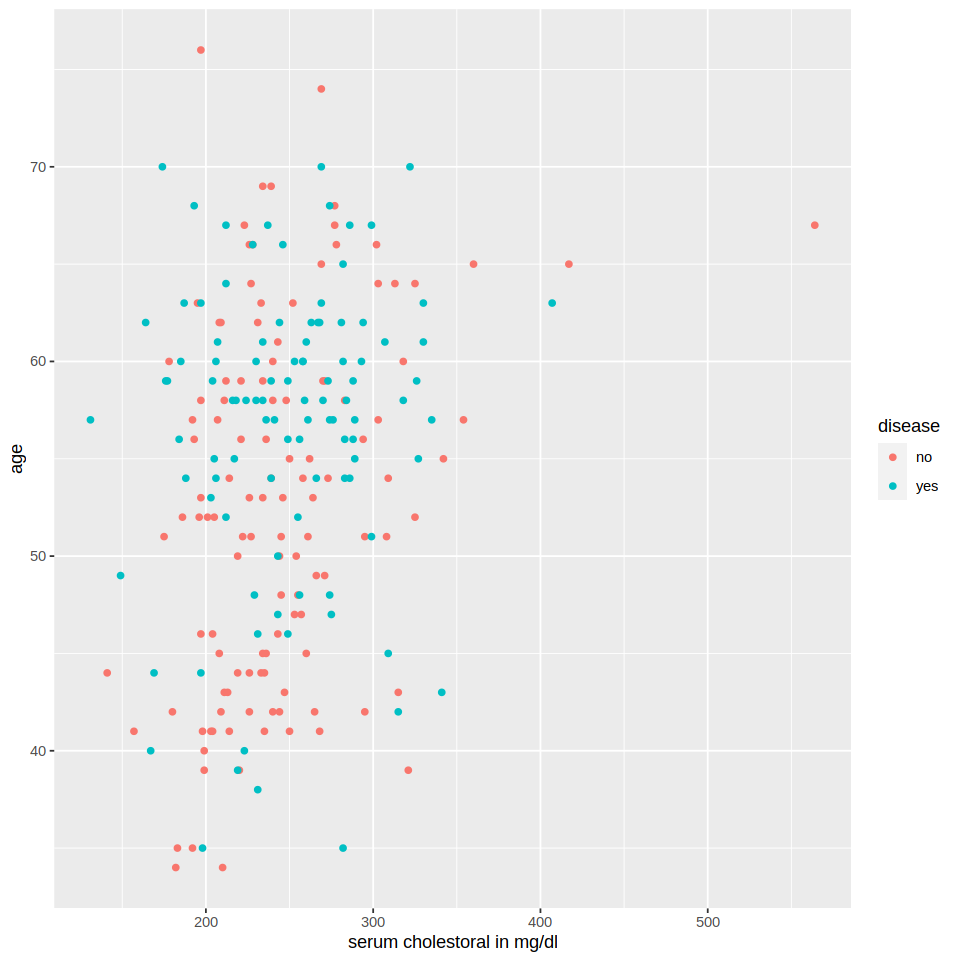

In [12]:
chol_age_plot <- ggplot(heart_train, aes(x = chol, y = age, color = disease)) +
                 geom_point() +
                 labs(x = "serum cholestoral in mg/dl", y = "age", color = "disease")
                 
chol_age_plot

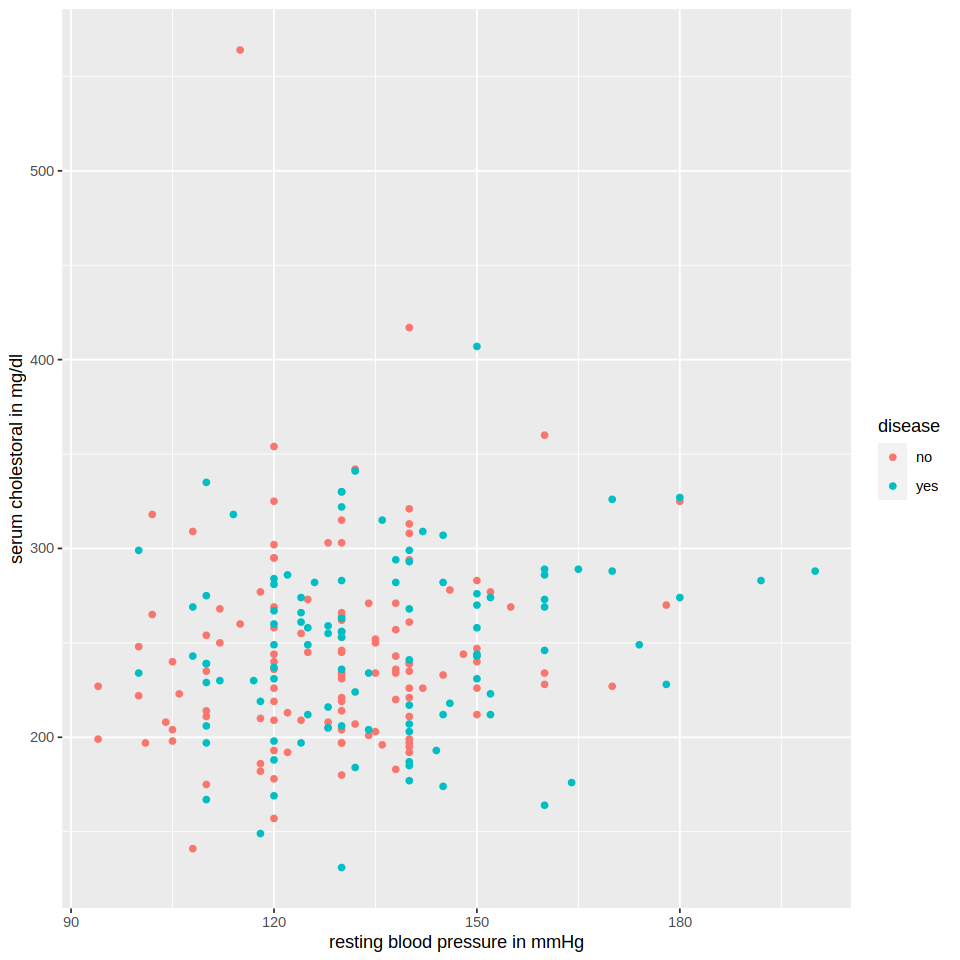

In [13]:
trestbps_chol_plot <- ggplot(heart_train, aes(x = trestbps, y = chol, color = disease)) +
                 geom_point() +
                 labs(x = "resting blood pressure in mmHg", y = "serum cholestoral in mg/dl", color = "disease")
                 
trestbps_chol_plot

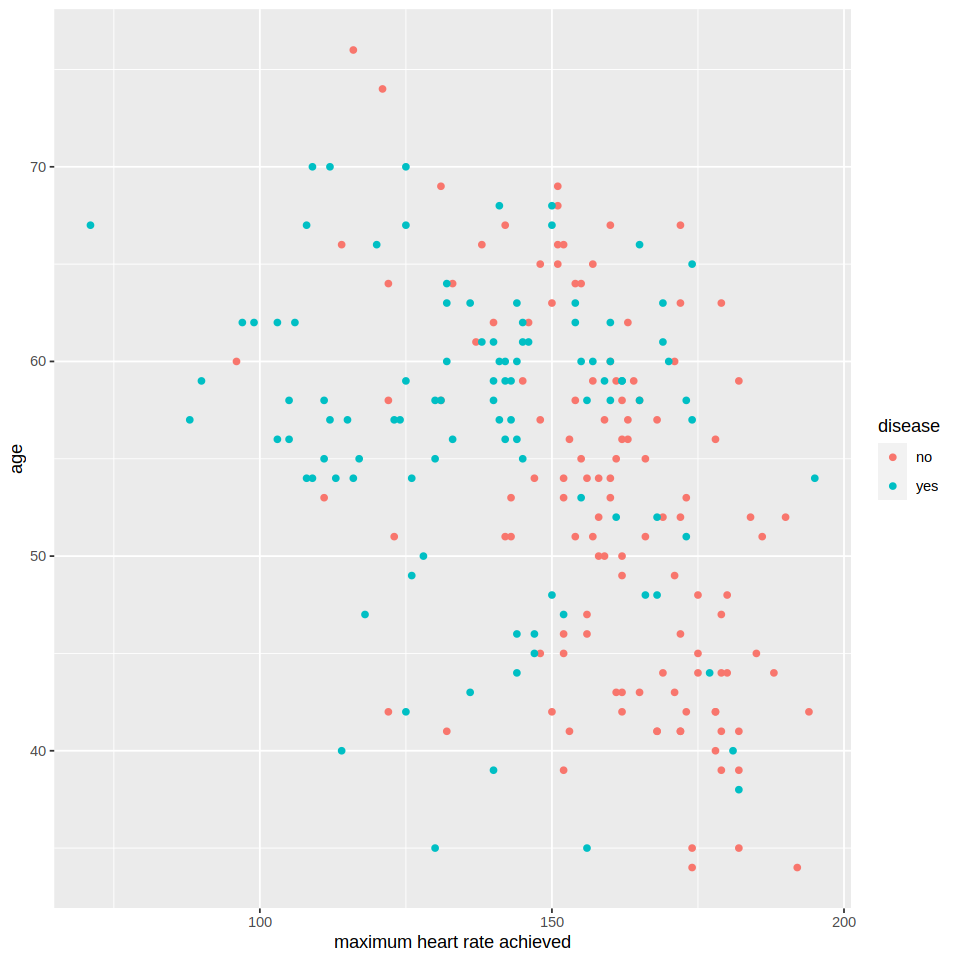

In [14]:
thalachs_age_plot <- ggplot(heart_train, aes(x = thalach, y = age, color = disease)) +
                 geom_point() +
                 labs(x = "maximum heart rate achieved", y = "age", color = "disease")
                 
thalachs_age_plot

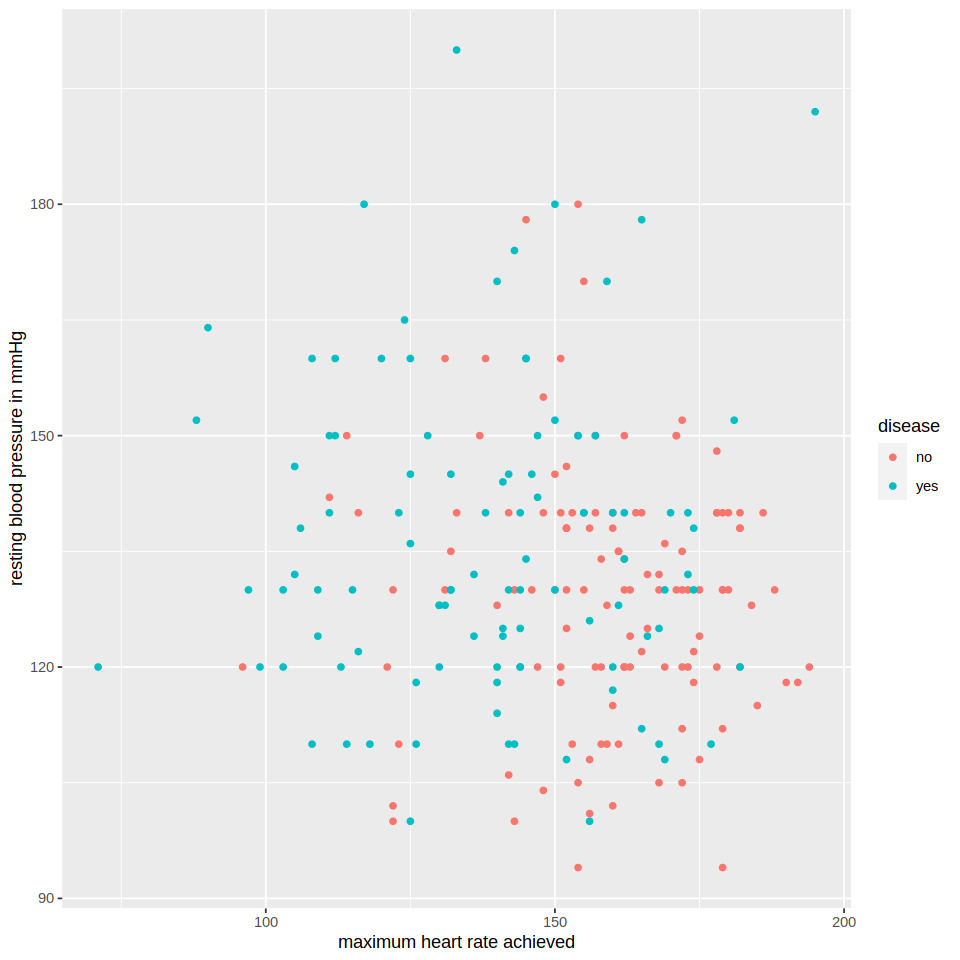

In [15]:
thalachs_trestbps_plot <- ggplot(heart_train, aes(x = thalach, y = trestbps, color = disease)) +
                 geom_point() +
                 labs(x = "maximum heart rate achieved", y = "resting blood pressure in mmHg", color = "disease")
                 
thalachs_trestbps_plot